# Nouvelle approche sur les données, traitement d'image. 

## Modules

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


import h5py

import librosa as lr

from sklearn.model_selection import train_test_split

import os 

In [37]:
path_test = '/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/X__test'
path = '/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/X_train'

## Création d'une fonction pour récupérer le spectrogramme 

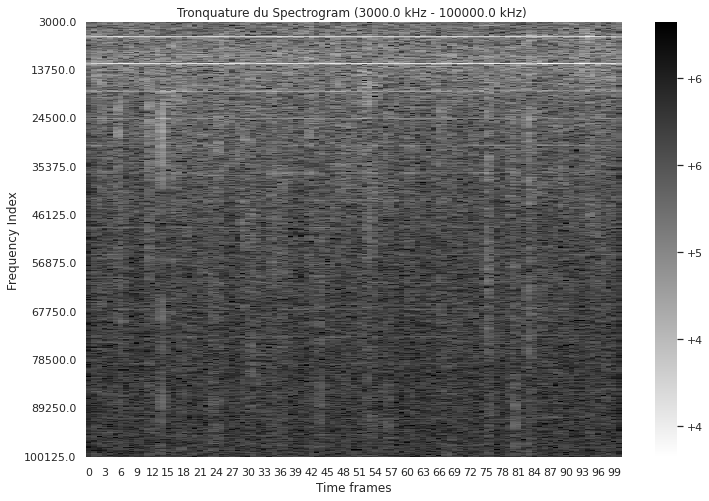

In [39]:
# Paramètres pour le calcul du STFT (Short-Time Fourier Transform)
n_fft = 2048  # Taille de la fenêtre FFT, peut être ajustée en fonction de vos besoins
fm = 3e3;fM=100e3 # Fréquence min et fréquence max
eps = 1e-6



def recup_spectrogram(path,display=True,fm = 1e3,fM=120e3,n_fft=2048):
    """
    Cette Fonction récupère le Spectrogramme du signal avec un passage en Log2 et une tronquature des fréquences
    """

    # Ouvrir le fichier WAV en mode lecture
    if path.endswith(".wav"):
        # Chargement du fichier audio
        sig, sr = lr.load(path, sr=None)
        eps = 1e-6

        # Calcul du STFT ## Transformée de Fourier roulante
        tf_sig = lr.stft(sig, n_fft=n_fft)

        # Conversion de l'amplitude en décibels et passage au log2 ## signe - car tout était négatif
        db_tf_sig = np.log(eps + np.abs( lr.amplitude_to_db(np.abs(tf_sig), ref=np.max) ) )/np.log(2) #np.abs(tf_sig) nécessaire pour des question d'invariance par déphasage

        # Récupérer les fréquences correspondantes du STFT
        frequences = lr.fft_frequencies(sr=sr, n_fft=n_fft)

        # Trouver les indices pour fm kHz et fM kHz
        low_freq_index = np.argmax(frequences >= fm) # prend le premier indice ou il y a un true dans la liste 
        high_freq_index = np.argmax(frequences >= fM) 

        # Tronquer les fréquences en dehors de fm kHz - fM kHz
        db_tf_tronq = db_tf_sig[low_freq_index:(high_freq_index+1),:]
        

        if display:
            # Configuration de Seaborn
            sns.set()
            # Création de la figure
            plt.figure(figsize=(12, 8))
            # Création de la heatmap
            ax = sns.heatmap(db_tf_tronq, cmap='gray_r', cbar_kws={'format': '%+2.0f'})

            # Récupération des fréquences pour l'étiquetage de l'axe y
            yticks = np.linspace(0, db_tf_tronq.shape[0], 10, dtype=int)

            yticklabels = np.round(frequences[low_freq_index:high_freq_index+2][yticks])
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticklabels)

            # Définir les étiquettes des axes
            ax.set_xlabel("Time frames")
            ax.set_ylabel("Frequency Index")

            # Titre du graphique
            ax.set_title(f"Tronquature du Spectrogram ({fm} kHz - {fM} kHz) ")

            plt.show()
        return np.expand_dims(db_tf_tronq, -1), frequences[low_freq_index:(high_freq_index+1)], 1
    else:
        print("Le fichier suivant n'est pas au format .wav",path)
        return 0,0,0



db_tf_tronq, frequences, bool1 = recup_spectrogram(os.path.join(path,'01105-JAM.wav'),display=True,fm = fm,fM=fM,n_fft=n_fft)


## récupérer les spectrogramme pour chaque enregistrement et les enregistrer dans un document

### Test_train

In [30]:
path_Y = '/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/Y_train_ofTdMHi.csv'

dico1_spec_train = {}
dico1_spec_train["ech"] = []
dico1_spec_train["spectrogramme"] = []
dico1_spec_train["post_label"] = []


dico1_spec_test = {}
dico1_spec_test["ech"] = []
dico1_spec_test["spectrogramme"] = []
dico1_spec_test["post_label"] = []

Y = pd.read_csv(path_Y,index_col='id')

Y_train, Y_test = train_test_split(Y,test_size=0.3, random_state=0)


In [33]:
for ech in Y_train.index:
    db_tf_tronq, freq , bool1 = recup_spectrogram(os.path.join(path,ech),display=False,fm = fm,fM=fM,n_fft=n_fft)  
    if bool1 == 1:
        dico1_spec_train["spectrogramme"].append(db_tf_tronq)
        dico1_spec_train["ech"].append(ech)
        dico1_spec_train["post_label"].append(Y_train.loc[ech]['pos_label'])

In [34]:
# Créer un fichier HDF5 pour stocker tous les spectrogrammes
with h5py.File('/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/spectrogrammes/spectrogrammes_train.h5', 'w') as h5f:
    for key, value in dico1_spec_train.items():
        h5f.create_dataset(key, data=value)

In [31]:
for ech in Y_test.index:
    db_tf_tronq, freq , bool1 = recup_spectrogram(os.path.join(path,ech),display=False,fm = fm,fM=fM,n_fft=n_fft)  
    if bool1 == 1:
        dico1_spec_test["spectrogramme"].append(db_tf_tronq)
        dico1_spec_test["ech"].append(ech)
        dico1_spec_test["post_label"].append(Y_test.loc[ech]['pos_label'])

In [32]:
# Créer un fichier HDF5 pour stocker tous les spectrogrammes
with h5py.File('/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/spectrogrammes/spectrogrammes_test.h5', 'w') as h5f:
    for key, value in dico1_spec_test.items():
        h5f.create_dataset(key, data=value)

### Validation

In [4]:
dico1_spec_test = {}
dico1_spec_test["ech"] = []
dico1_spec_test["spectrogramme"] = []

for ech in os.listdir(path_test):
    db_tf_tronq, freq , bool1 = recup_spectrogram(os.path.join(path_test,ech),display=False,fm = fm,fM=fM,n_fft=n_fft)  
    if bool1 == 1:
        dico1_spec_test["spectrogramme"].append(db_tf_tronq)
        dico1_spec_test["ech"].append(ech)

Le fichier suivant n'est pas au format .wav /home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/X__test/.DS_Store
Le fichier suivant n'est pas au format .wav /home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/X__test/.zip


In [10]:
# Créer un fichier HDF5 pour stocker tous les spectrogrammes
with h5py.File('/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/spectrogrammes/spectrogrammes_val.h5', 'w') as h5f:
    for key, value in dico1_spec_test.items():
        h5f.create_dataset(key, data=value)
        

# Modélisation des données

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


import h5py

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

from sklearn.metrics import accuracy_score,f1_score # pour voir l'efficacité globale du modèle
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


2023-12-30 11:50:16.271121: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-30 11:50:16.802645: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-30 11:50:16.802735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-30 11:50:16.878505: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-30 11:50:17.059435: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-30 11:50:17.061486: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
# Chemin vers vos fichiers HDF5
train_filepath = '/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/spectrogrammes/spectrogrammes_train.h5'
test_filepath = '/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/spectrogrammes/spectrogrammes_test.h5'
val_filepath = '/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/spectrogrammes/spectrogrammes_val.h5'

In [4]:
# Créez une fonction qui génère des lots de données à partir des fichiers HDF5 car on ne peut pas les charger entier
def data_generator(filepath, batch_size):
    while True:
        with h5py.File(filepath, 'r') as file:
            num_samples = file['spectrogramme'].shape[0] #nb de spectrogramme
            num_batches = num_samples // batch_size 

            # Créez un tableau d'indices aléatoires pour un nb d'echantillons ceci à chaque epoch 
            #random_indices = np.random.permutation(num_samples)

            for i in range(num_batches):
                start = i * batch_size
                end = (i + 1) * batch_size

                # Sélectionnez les indices aléatoires pour ce lot
                #batch_indices = random_indices[start:end]

                X_batch = file['spectrogramme'][start:end]#[batch_indices]  # Chargez les spectrogrammes
                y_batch = file['post_label'][start:end] #[batch_indices]  # Chargez les étiquettes 

                yield X_batch, y_batch 


In [14]:
epochs = 5
lr = 0.0005
batch_size = 40

with h5py.File(train_filepath, 'r') as train_file:
    input_shape = train_file['spectrogramme'][0].shape #nb de spectrogramme

# Modèle CNN
model = Sequential()

# Couche de convolution 1
model.add(Conv2D(16, kernel_size=(9, 9), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Aplatir les sorties pour les couches denses
model.add(Flatten())

# Couches entièrement connectées
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))  # Sortie binaire

adam_optimizer = Adam(learning_rate=lr)

# Compiler le modèle
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

# Créez des générateurs de données pour l'entraînement, la validation et les tests
train_generator = data_generator(train_filepath, batch_size)
test_generator = data_generator(test_filepath, batch_size)

with h5py.File(train_filepath, 'r') as train_file, h5py.File(test_filepath,'r') as test_file:
            num_train_samples = train_file['spectrogramme'].shape[0] #nb de spectrogramme
            num_test_samples = test_file['spectrogramme'].shape[0] #nb de spectrogramme


history = model.fit(
    train_generator, # Utilisez le générateur de données d'entraînement
    steps_per_epoch=num_train_samples // batch_size, #nb d'étape par epoch
    epochs=epochs,
    validation_data=test_generator,  # Utilisez le générateur de données de test pour la validation
    validation_steps=num_test_samples // batch_size  # Définissez le nombre d'étapes de validation
)
   

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 929, 93, 16)       1312      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 464, 46, 16)       0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 341504)            0         
                                                                 
 dense_12 (Dense)            (None, 256)               87425280  
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                      

In [16]:
adam_optimizer = Adam(learning_rate=lr/10)

# Compiler le modèle
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator, # Utilisez le générateur de données d'entraînement
    steps_per_epoch=num_train_samples // batch_size, #nb d'étape par epoch
    epochs=3,
    validation_data=test_generator,  # Utilisez le générateur de données de test pour la validation
    validation_steps=num_test_samples // batch_size  # Définissez le nombre d'étapes de validation
)

Epoch 1/3
405/405 [==============================] - 1131s 3s/step - loss: 0.1398 - accuracy: 0.9525 - val_loss: 0.2036 - val_accuracy: 0.9243
Epoch 2/3
405/405 [==============================] - 1128s 3s/step - loss: 0.1349 - accuracy: 0.9543 - val_loss: 0.2081 - val_accuracy: 0.9234
Epoch 3/3
405/405 [==============================] - 1125s 3s/step - loss: 0.1299 - accuracy: 0.9566 - val_loss: 0.2046 - val_accuracy: 0.9244


## sauvegarde du modèle

In [4]:
import pickle

# Chargez le modèle à partir du fichier
with open('/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/neuro_conv1.pkl', 'rb') as fichier:
    modele = pickle.load(fichier)

"""# Sauvegardez le modèle dans un fichier
with open('/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/neuro_conv1.pkl', 'wb') as fichier:
    pickle.dump(model, fichier)"""

"# Sauvegardez le modèle dans un fichier\nwith open('/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/neuro_conv1.pkl', 'wb') as fichier:\n    pickle.dump(model, fichier)"

In [28]:
#Charger les données test

with h5py.File(test_filepath, 'r') as file:
    spectres_test = file['spectrogramme'][:]
    post_label = file['post_label'][:]
    ech_test = file['ech'][:]

ech_tests = []
for stri in ech_test:
    ech_tests.append(stri.decode('utf-8'))


In [30]:
#Charger les données val

with h5py.File(val_filepath, 'r') as file:
    spectres_val = file['spectrogramme'][:]
    ech_val = file['ech'][:]

ech_vals = []
for stri in ech_val:
    ech_vals.append(stri.decode('utf-8'))

2023-12-30 12:02:52.163300: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2631287148 exceeds 10% of free system memory.


218/218 [==============================] - 80s 368ms/step
voici le seuil médian 0.38698718
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.93      4140
         1.0       0.89      0.92      0.91      2811

    accuracy                           0.92      6951
   macro avg       0.92      0.92      0.92      6951
weighted avg       0.92      0.92      0.92      6951



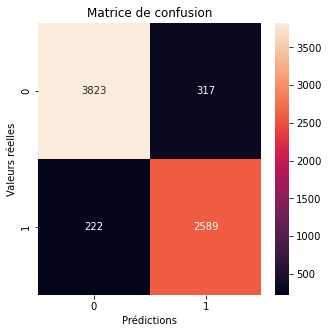

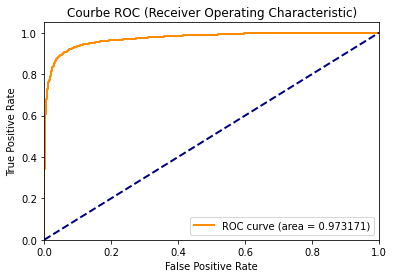

In [31]:
# Prédire les probabilités pour la classe positive
y_proba_pred_test = modele.predict(spectres_test)

# Calculer les scores TPR (True Positive Rate) et FPR (False Positive Rate)
fpr, tpr, thresholds = roc_curve(post_label, y_proba_pred_test)

#Trouver le bon indice pour le seuil de décision, au milieu de la courbe Roc
indice = int(np.floor(len(thresholds)/2))
print( "voici le seuil médian" ,thresholds[indice-1])

# Calculer l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

#Prédiction sur le seuil précédent
Y_pred = y_proba_pred_test > thresholds[indice-1]

#Rapport de classification  
matrix_conf = confusion_matrix(post_label,Y_pred)
print(classification_report(post_label,Y_pred))

##Matrice de confusion 
plt.figure(figsize=(5,5))
sns.heatmap(matrix_conf,annot=True,fmt='g')
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.show()


# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.6f})') # aire sous la courbe
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.show()


In [33]:
# Prédire les probabilités pour la classe positive
y_proba_pred_val = modele.predict(spectres_val)


30/30 [==============================] - 12s 395ms/step


In [34]:
df_soumission8 = pd.DataFrame(ech_vals)
df_soumission8['pos_label'] = y_proba_pred_val
df_soumission8.index = df_soumission8[0]
df_soumission8.index.name = "id"
df_soumission8.drop(columns=0,axis=1,inplace=True)
df_soumission8.to_csv("/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/Data_challenge/soumission8.csv")


<AxesSubplot:>

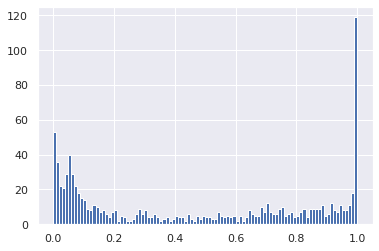

In [51]:
df_soumission8.pos_label.hist(bins=100, density=False, label='proba de validation')

### Modèle préentrainé

In [ ]:
# Créez une fonction qui génère des lots de données à partir des fichiers HDF5 car on ne peut pas les charger entier
def data_generator(filepath, batch_size):
    while True:
        with h5py.File(filepath, 'r') as file:
            num_samples = file['spectrogramme'].shape[0] #nb de spectrogramme
            num_batches = num_samples // batch_size 

            # Créez un tableau d'indices aléatoires pour un nb d'echantillons ceci à chaque epoch 
            #random_indices = np.random.permutation(num_samples)

            for i in range(num_batches):
                start = i * batch_size
                end = (i + 1) * batch_size

                # Sélectionnez les indices aléatoires pour ce lot
                #batch_indices = random_indices[start:end]

                X_batch = file['spectrogramme'][start:end]#[batch_indices]  # Chargez les spectrogrammes
                y_batch = file['post_label'][start:end] #[batch_indices]  # Chargez les étiquettes 

                yield np.repeat(X_batch, 3, axis=-1), y_batch  #Mettre au format RGB


In [31]:
with h5py.File(train_filepath, 'r') as train_file:
            input_shape =  train_file['spectrogramme'][0].shape #nb de spectrogramme

# Charger le modèle VGG16 avec des poids ImageNet 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(937, 101, 3))

"""ImageNet est une gigantesque base de données de plus de 14 millions d’images labellisées réparties
 dans plus de 1000 classes, en 2014. En 2007, une chercheuse du nom de Fei-Fei Li a commencé à travailler 
 sur l’idée de créer un tel jeu de données. """

# Remplacer la couche de sortie par une nouvelle couche pour la classification binaire
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='sigmoid')(x)  # Sortie binaire

# Créer le modèle complet
model = Model(inputs=base_model.input, outputs=x)

# Congeler toutes les couches sauf la nouvelle couche de sortie
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle
adam_optimizer = Adam(learning_rate=0.001)  # Taux d'apprentissage pour Adam
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Afficher le résumé du modèle
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 937, 101, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 937, 101, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 937, 101, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 468, 50, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 468, 50, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 468, 50, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 234, 25, 128)      0   

In [ ]:
epochs = 4
batch_size = 50
   
# Créez des générateurs de données pour l'entraînement, la validation et les tests
train_generator = data_generator(train_filepath, batch_size)
test_generator = data_generator(test_filepath, batch_size)

with h5py.File(train_filepath, 'r') as train_file, h5py.File(test_filepath,'r') as test_file:
            num_train_samples = train_file['spectrogramme'].shape[0] #nb de spectrogramme
            num_test_samples = test_file['spectrogramme'].shape[0] #nb de spectrogramme


history = model.fit(
    train_generator, # Utilisez le générateur de données d'entraînement
    steps_per_epoch=num_train_samples // batch_size, #nb d'étape par epoch
    epochs=epochs,
    validation_data=test_generator,  # Utilisez le générateur de données de test pour la validation
    validation_steps=num_test_samples // batch_size  # Définissez le nombre d'étapes de validation
)

# Réseau convolutionnel 2